# Kaggle_House Price Prediction
- 집에 대한 여러 feature를 통해 price 예측
- 외부 데이터 사용금지
- 하루 5번 제출 가능
- 개인으로만 참가 가능 (팀 X)

(https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr/overview)

## 평가 방법 
: **RMSE** (Root Mean Squared Error)

## File descriptions
- train.csv : 예측 모델을 만들기 위해 사용하는 학습 데이터입니다. 집의 정보와 예측할 변수인 가격(Price) 변수를 가지고 있습니다.
- test.csv : 학습셋으로 만든 모델을 가지고 예측할 가격(Price) 변수를 제외한 집의 정보가 담긴 테스트 데이터 입니다.
- sample_submission.csv : 제출시 사용할 수 있는 예시 submission.csv 파일입니다.

## import Package

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

## 데이터 불러오기

In [2]:
train_path = '../Data/Exploration.05/kaggle-kakr-housing-data/data/train.csv'
test_path = '../Data/Exploration.05/kaggle-kakr-housing-data/data/test.csv'

In [3]:
train = pd.read_csv(train_path)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [4]:
test = pd.read_csv(test_path)
test.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


In [5]:
train.shape, test.shape

((15035, 21), (6468, 20))

### train 데이터셋
    - 15,035개
    - 21개의 columns
    
### test 데이터셋
    - 6,468개
    - 20개의 columns (예측해야할 대상인 price는 제외)

In [6]:
train_len = len(train)
data = pd.concat((train, test), axis=0, ignore_index=True)

len(data)

21503

data
- train과 test를 합쳐줌
- axis=0으로 지정하여 행쪽으로 합침
- 전처리를 완료한 후에 다시 train_len을 통해 train과 test를 나눠줄 예정
- ignore_index=True : False로 concat을 하게되면 train과 test에 지정된 index가 서로 겹치게 됨

## 데이터 살펴보기

### 1. 각 columns 파악하기

In [7]:
data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

**<kaggle 코리아에서 설명한 변수의 내용>**  
- ID : 집을 구분하는 번호  
- date : 집을 구매한 날짜  
- price : 집의 가격(Target variable)  
- bedrooms : 침실의 수  
- bathrooms : 화장실의 수  
- sqft_living : 주거 공간의 평방 피트(면적)  
- sqft_lot : 부지의 평방 피트(면적)  
- floors : 집의 층 수  
- waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)  
- view : 집이 얼마나 좋아 보이는지의 정도  
- condition : 집의 전반적인 상태  
- grade : King County grading 시스템 기준으로 매긴 집의 등급  
- sqft_above : 지하실을 제외한 평방 피트(면적)  
- sqft_basement : 지하실의 평방 피트(면적)  
- yr_built : 지어진 년도  
- yr_renovated : 집을 재건축한 년도  
- zipcode : 우편번호  
- lat : 위도  
- long : 경도  
- sqft_living15 : 2015년 기준 주거 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)  
- sqft_lot15 : 2015년 기준 부지의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)  

**각 변수에서의 오류**
- price : 구매할 시점에서의 가격인지, 현재 시점에서 예상되는 가치인지 명시되지 않음
- sqft_living15 : 데이터는 14년 5월부터 있음. 15년도 기준 재건축은 14년도 price와 상관이 없음

**<변수에 대해 찾아본 내용>**  
https://rstudio-pubs-static.s3.amazonaws.com/155304_cc51f448116744069664b35e7762999f.html

- id : Unique ID for each home sold
- date : Date of the home sale
- price : Price of each home sold
- bedrooms : Number of bedrooms
- bathrooms : Number of bathrooms, where .5 accounts for a room with a toilet but no shower
- sqft_living : Square footage of the apartments interior living space
- sqft_lot : Square footage of the land space
- floors : Number of floors
- waterfront : A dummy variable for whether the apartment was overlooking the waterfront or not
- view : An index from 0 to 4 of how good the view of the property was
- condition : An index from 1 to 5 on the condition of the apartment,
- grade : An index from 1 to 13, where 1-3 falls short of building construction and design, 7 has an average level of construction and design, and 11-13 have a high quality level of construction and design.

- sqft_above : The square footage of the interior housing space that is above ground level
- sqft_basement : The square footage of the interior housing space that is below ground level
- yr_built : The year the house was initially built
- yr_renovated : The year of the house’s last renovation
- zipcode : What zipcode area the house is in
- lat : Lattitude
- long : Longitude
- sqft_living15 : The square footage of interior housing living space for the nearest 15 neighbors
- sqft_lot15 : The square footage of the land lots of the nearest 15 neighbors

**영어로 된 변수 해석이 문제 상황에 더 알맞음**
- price : 집 판매 가격
- living15 : 가장 가까운 15 이웃의 주거공간 면적

### 2. 데이터 전체적으로 확인

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21503 entries, 0 to 21502
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21503 non-null  int64  
 1   date           21503 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       21503 non-null  int64  
 4   bathrooms      21503 non-null  float64
 5   sqft_living    21503 non-null  int64  
 6   sqft_lot       21503 non-null  int64  
 7   floors         21503 non-null  float64
 8   waterfront     21503 non-null  int64  
 9   view           21503 non-null  int64  
 10  condition      21503 non-null  int64  
 11  grade          21503 non-null  int64  
 12  sqft_above     21503 non-null  int64  
 13  sqft_basement  21503 non-null  int64  
 14  yr_built       21503 non-null  int64  
 15  yr_renovated   21503 non-null  int64  
 16  zipcode        21503 non-null  int64  
 17  lat            21503 non-null  float64
 18  long  

전처리를 거치며 데이터를 최대한 정수형 또는 실수형으로 표현하고자 함

### 3. 결측치 파악하기

In [9]:
data.isnull().sum()

id                  0
date                0
price            6468
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront          0
view                0
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated        0
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [10]:
train.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

**결측치는 없음**  
(price의 결측치는 test데이터 쪽의 label값에 해당함)

### 4. 상관관계 이미지로 보기

상관관계 히트맵을 그리기 전에 양적 자료만 모으고자 함  
(범주형 자료는 숫자로 표현되어 있더라도 heatmap을 통해 상관관계를 판단하기 어려움)

In [11]:
data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [12]:
heatmap_data = data[['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'view', 'condition', 'grade', 
                      'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']]
heatmap_data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,sqft_basement,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0,3,7,1180,0,1340,5650
1,180000.0,2,1.00,770,10000,1.0,0,3,6,770,0,2720,8062
2,510000.0,3,2.00,1680,8080,1.0,0,3,8,1680,0,1800,7503
3,257500.0,3,2.25,1715,6819,2.0,0,3,7,1715,0,2238,6819
4,291850.0,3,1.50,1060,9711,1.0,0,3,7,1060,0,1650,9711


<AxesSubplot:>

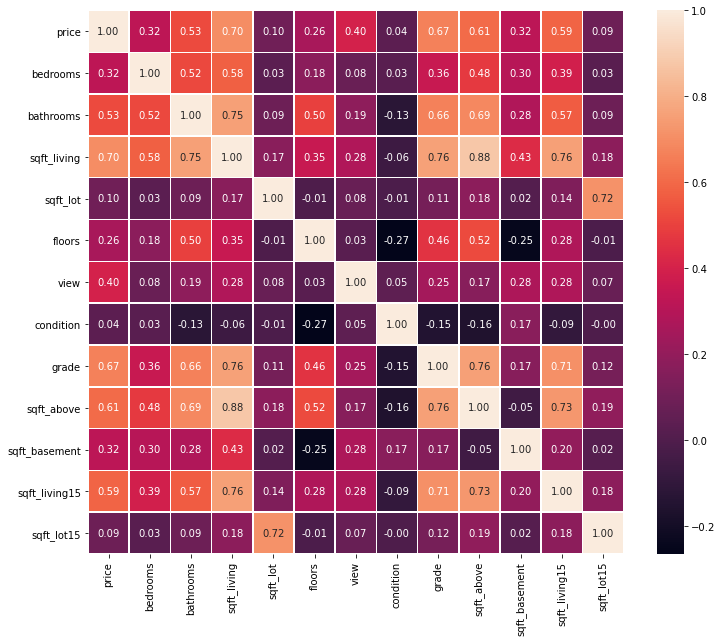

In [13]:
plt.figure(figsize=(12,10))
sns.heatmap(data = heatmap_data.corr(), annot=True, fmt = '.2f', linewidths=.5)

**Price와의 다른 변수들과의 상관관계를 보고자 함** 
- 상관관계가 비교적 높은 것 (0.65 이상) : sqft_living (주거 공간의 평방 피트(면적)), grade(집의 등급)  
- 상관관계가 비교적 낮은 것 (0.3 이하) : sqft_lot(부지의 면적), floors(층수), condition(집의 전반적인 상태), sqft_lot15(이웃의 부지 면적) 
- 전처리 과정을 보면서 상관관계가 낮은 변수들을 어떻게 처리할지 고민하고자 함

## Preprocessing (전처리)

### 1. date의 날짜 형태 바꾸기

In [14]:
data['date'].head()

0    20141013T000000
1    20150225T000000
2    20150218T000000
3    20140627T000000
4    20150115T000000
Name: date, dtype: object

In [15]:
data['date'] = data['date'].apply(lambda x : str(x[:6])).astype(str)
data['date'].head()

0    201410
1    201502
2    201502
3    201406
4    201501
Name: date, dtype: object

In [16]:
data['date'] = data['date'].astype(int)

In [17]:
type(data['date'][0])

numpy.int32

- 문자열 슬라이싱으로 통해 연도와 월에 해당하는 내용만 남김
- date를 문자열에서 정수형으로 변환

<AxesSubplot:xlabel='date', ylabel='count'>

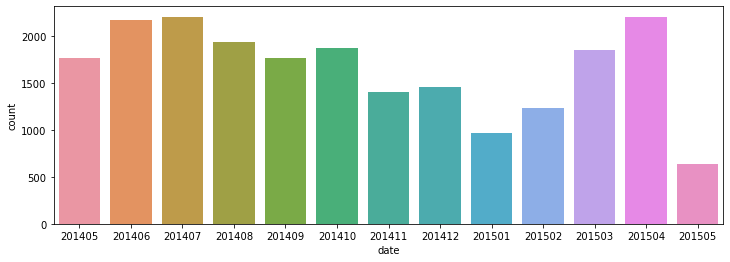

In [18]:
figure = plt.figure(figsize=(12,4))
sns.countplot(data=data, x='date')

연도,월별 주택 구매량 파악 : 주택 구매량은 월별 영향을 받지만 기간이 짧아 패턴을 분석하기는 어려움

<AxesSubplot:xlabel='date', ylabel='price'>

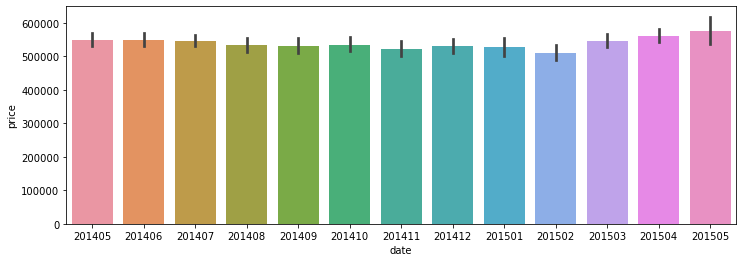

In [19]:
figure = plt.figure(figsize=(12,4))
sns.barplot(data=data, x='date', y='price')

date를 feature에서 제외할 예정
- 데이터셋에서의 기간동안 기간에 따른 가격 차이에 대한 상관관계는 보기 어려움
- 연도와 월별 숫자가 표현하는 값이 feature로 선정하기 애매함
    - 숫자의 크고 작음이 모델 학습에 영향을 줄 것으로 판단
    - 구매 연도와 월은 범주형 데이터임
    - 원핫인코딩으로 feature에 넣으려 했으나 범주가 많아 중요하지 않는 특성들이 많아질 가능성이 있음
    - date를 원핫인코딩으로 나타내는 것은 오히려 성능 저하가 발생할 수 있다고 판단됨

### 2. 그래프로 Price와의 관련성 파악해보기

In [20]:
data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [21]:
plot_list = ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'grade']

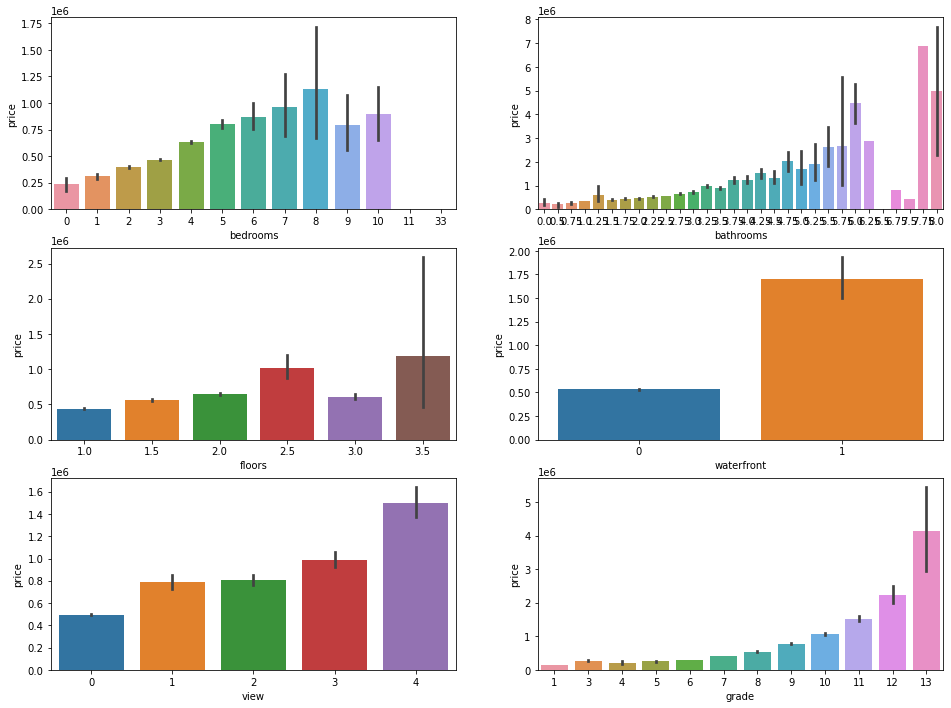

In [22]:
fig = plt.figure(figsize=(16,12))

for idx, l in enumerate(plot_list):
    idx = idx + 1
    axes = 'ax' + str(idx)
    axes = fig.add_subplot(3,2,idx)
    sns.barplot(data=data, y="price", x=l)

plt.show()

위 그래프의 변수들은 정비례는 아니지만 price에 영향을 주는 요소가 될 수 있다고 판단됨

In [23]:
data['bathrooms'].unique()

array([1.  , 2.  , 2.25, 1.5 , 2.5 , 1.75, 3.  , 2.75, 3.25, 4.  , 3.5 ,
       0.75, 4.75, 5.  , 4.25, 4.5 , 3.75, 5.25, 6.  , 1.25, 0.5 , 5.5 ,
       6.75, 5.75, 0.  , 8.  , 7.5 , 7.75, 6.25, 6.5 ])

In [24]:
plot_list2 = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']

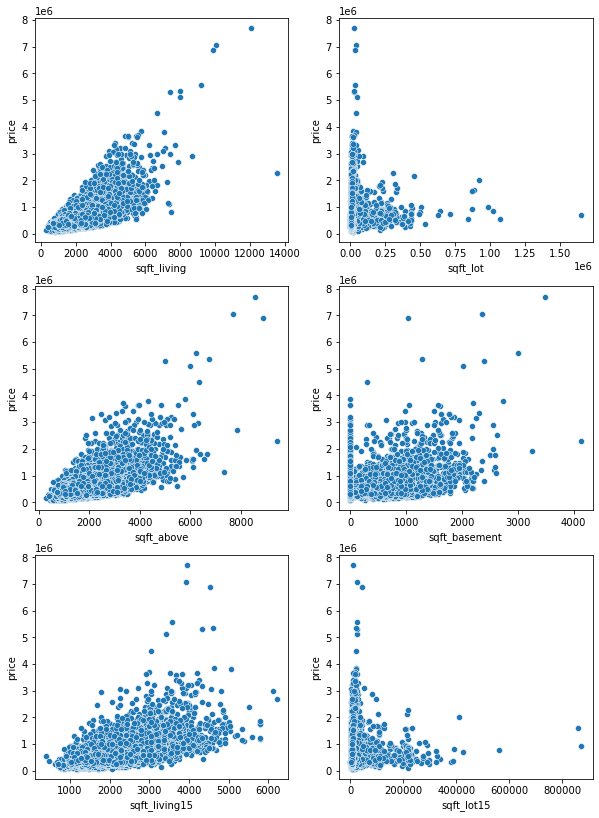

In [25]:
fig = plt.figure(figsize=(10,14))

for idx, l in enumerate(plot_list2):
    idx = idx + 1
    axes = 'ax' + str(idx)
    axes = fig.add_subplot(3,2,idx)
    sns.scatterplot(data=data, y="price", x=l)

plt.show()

- price간의 격차가 너무 커서 그래프를 제대로 파악하긴 어렵다고 생각됨  
- 'sqft_lot'과 'sqft_lot15'는 0의 값이 매우 많아 파악하기 어려움
    - 다른 변수에 비해 지하실은 없는 경우가 많음
    - 0 이상의 값만 가지고 다시 그래프를 봐야할 것으로 판단됨  
- 'sqft_basement'를 제외한 다른 변수들은 price와 어느 정도 관계가 있다고 판단 됨

In [26]:
lot_temp = data[(data['sqft_lot'] > 30000) & (data['sqft_lot'] < 1650000)]

In [27]:
lot_temp15 = data[(data['sqft_lot15'] > 30000) & (data['sqft_lot15'] < 1650000)]

<AxesSubplot:xlabel='sqft_lot15', ylabel='price'>

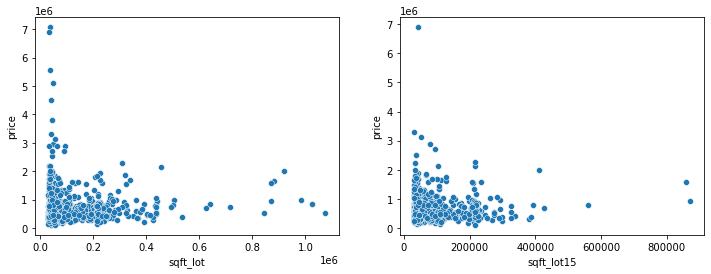

In [28]:
fig = plt.figure(figsize=(12,4))
axes = fig.add_subplot(1,2,1)
sns.scatterplot(data=lot_temp, y="price", x='sqft_lot')
axes = fig.add_subplot(1,2,2)
sns.scatterplot(data=lot_temp15, y="price", x='sqft_lot15')

- 'sqft_lot', 'sqft_lot15'와 price의 상관관계를 그래프로 보려고 함
- 지하실 평수가 너무 작은 값과 너무 큰 값을 제외하고 scatterplot으로 표현해봄
- 뚜렷한 상관관계는 없다고 판단되지만 어느 정도 영향은 있을 것으로 예상됨

### 3. zipcode를 활용하여 city 도출
- zipcode는 범주형 데이터이므로 원핫인코딩이 필요함
- zipcode를 그대로 원핫인코딩하게 되면 feature의 수가 너무 많아짐
- zipcode를 통해 city를 도출하고 city를 원핫인코딩할 예정

In [29]:
data['zipcode'].unique()

array([98178, 98028, 98074, 98003, 98198, 98007, 98115, 98107, 98126,
       98019, 98103, 98002, 98133, 98040, 98030, 98119, 98112, 98027,
       98117, 98058, 98001, 98056, 98166, 98053, 98023, 98105, 98042,
       98008, 98148, 98122, 98004, 98005, 98034, 98125, 98075, 98010,
       98038, 98059, 98092, 98136, 98199, 98032, 98045, 98102, 98077,
       98108, 98168, 98177, 98118, 98006, 98146, 98033, 98052, 98155,
       98024, 98116, 98144, 98011, 98031, 98106, 98065, 98022, 98070,
       98014, 98055, 98072, 98029, 98188, 98109, 98039], dtype=int64)

In [30]:
from pyzipcode import ZipCodeDatabase
zcdb = ZipCodeDatabase()

zipcode에서 정보를 알아올 수 있는 라이브러리 import

In [31]:
data['zipcode'][0]

98178

In [32]:
zcdb[98178]

ZipCode(zip='98178', city='Seattle', state='WA', longitude=-122.24664, latitude=47.497971, timezone=-8, dst=1)

In [33]:
zcdb[data['zipcode'][0]].city

'Seattle'

In [34]:
data['city'] = 0

- data['city']에 0값을 넣고 새로운 column을 생성함

In [35]:
for i, j in zip(data['zipcode'], data.index):
    if i == 98077 :
        continue
    else :
        ct = zcdb[i].city
        data['city'][j] = ct

- data['city']에 zipcode에 해당하는 도시명을 넣어줌
- zipcode 98077은 라이브러리에서 찾지 못해 직접 넣어줄 예정
- 구글 검색 결과 98077은 Seattle의 zipcode임

In [36]:
data[data['city'] == 0][['zipcode', 'city']].head()

,zipcode,city
69,98077,0
72,98077,0
95,98077,0
167,98077,0
192,98077,0


In [37]:
data.loc[data['city'] == 0, 'city'] = 'Seattle'

In [38]:
data[data['city'] == 0][['zipcode', 'city']].head()

,zipcode,city


In [39]:
data[data['zipcode'] == 98077][['zipcode', 'city']].head()

,zipcode,city
69,98077,Seattle
72,98077,Seattle
95,98077,Seattle
167,98077,Seattle
192,98077,Seattle


In [40]:
data['city'].unique()

array(['Seattle', 'Kenmore', 'Sammamish', 'Federal Way', 'Bellevue',
       'Duvall', 'Auburn', 'Mercer Island', 'Kent', 'Issaquah', 'Renton',
       'Redmond', 'Kirkland', 'Black Diamond', 'Maple Valley',
       'North Bend', 'Fall City', 'Bothell', 'Snoqualmie', 'Enumclaw',
       'Vashon', 'Carnation', 'Woodinville', 'Medina'], dtype=object)

<AxesSubplot:xlabel='city', ylabel='count'>

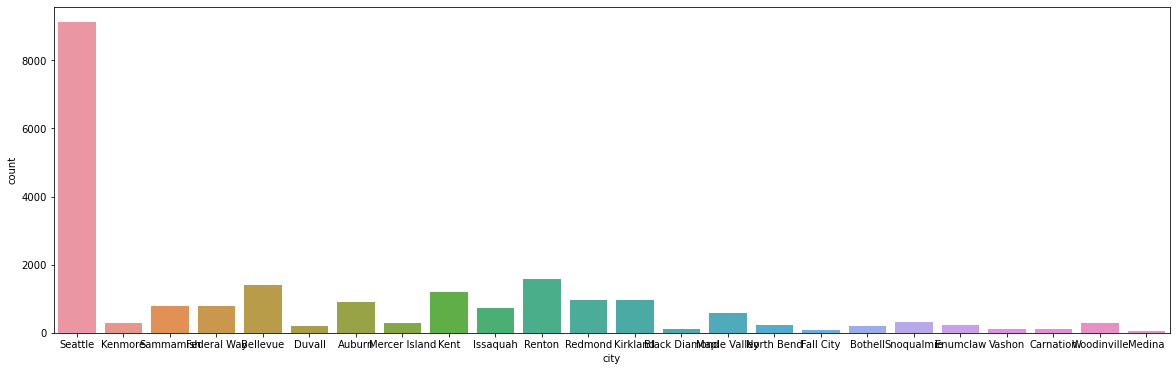

In [41]:
figure = plt.figure(figsize=(20, 6))
sns.countplot(data=data, x='city')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 [Text(0, 0, 'Seattle'),
  Text(1, 0, 'Kenmore'),
  Text(2, 0, 'Sammamish'),
  Text(3, 0, 'Federal Way'),
  Text(4, 0, 'Bellevue'),
  Text(5, 0, 'Duvall'),
  Text(6, 0, 'Auburn'),
  Text(7, 0, 'Mercer Island'),
  Text(8, 0, 'Kent'),
  Text(9, 0, 'Issaquah'),
  Text(10, 0, 'Renton'),
  Text(11, 0, 'Redmond'),
  Text(12, 0, 'Kirkland'),
  Text(13, 0, 'Black Diamond'),
  Text(14, 0, 'Maple Valley'),
  Text(15, 0, 'North Bend'),
  Text(16, 0, 'Fall City'),
  Text(17, 0, 'Bothell'),
  Text(18, 0, 'Snoqualmie'),
  Text(19, 0, 'Enumclaw'),
  Text(20, 0, 'Vashon'),
  Text(21, 0, 'Carnation'),
  Text(22, 0, 'Woodinville'),
  Text(23, 0, 'Medina')])

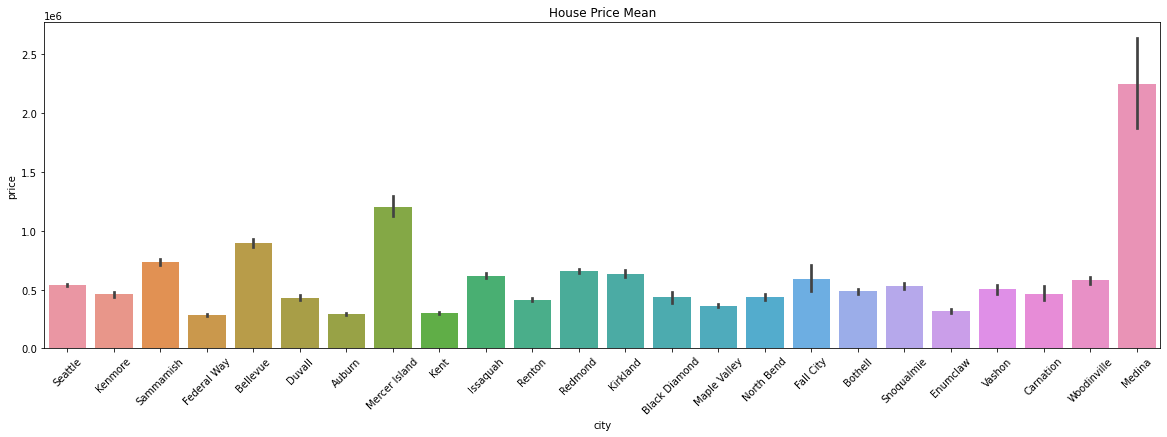

In [42]:
figure = plt.figure(figsize=(20, 6))
plt.title('House Price Mean')
sns.barplot(data=data, x='city', y='price')
plt.xticks(rotation=45)

- 도시별로 집값이 뚜렷하게 차이 난다고 판단하여 원핫인코딩을 통해 city를 feature로 넣어주려고 함
- 집값의 평균이 가장 높은 도시는 'Medina'

- city를 모두 원핫인코딩하면 24개의 feature가 추가됨
- city별 price 평균을 비교하여 그룹으로 만들고 feature로 추가하고자 함

- Medina의 평균 집값이 압도적으로 높아서 제외하고 다른 city의 평균 집값을 보고자함

In [43]:
city_temp = data[['price', 'city']]

In [44]:
city_not_medina = city_temp[city_temp['city'] !='Medina']

In [45]:
city_not_medina['price'].describe()

count    1.499900e+04
mean     5.365899e+05
std      3.574330e+05
min      7.800000e+04
25%      3.210000e+05
50%      4.500000e+05
75%      6.422250e+05
max      7.700000e+06
Name: price, dtype: float64

<AxesSubplot:xlabel='city', ylabel='price'>

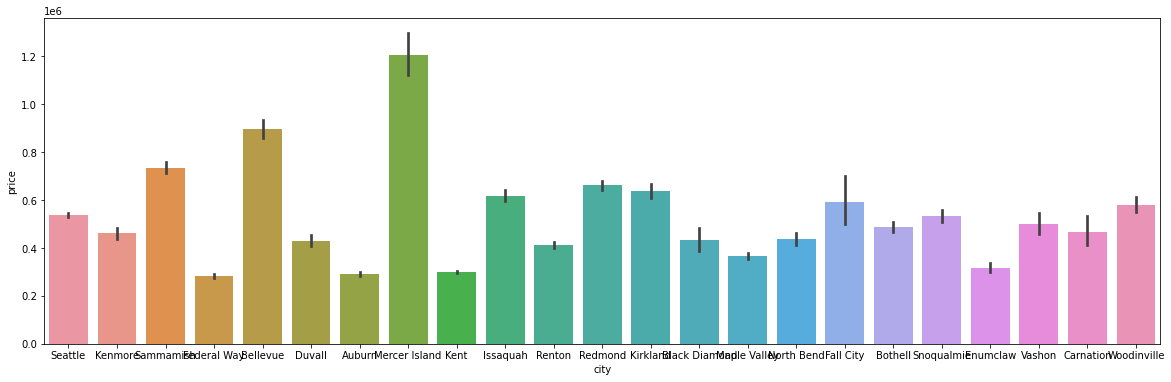

In [46]:
figure = plt.figure(figsize=(20, 6))
sns.barplot(data=city_not_medina, x='city', y='price')

- 비교적 너무 높은 price를 가지는 Medina를 제외하고 그래프를 봄
- 육안으로는 일부 city를 제외하고 집값의 평균은 매우 큰 차이를 보이지 않음

In [47]:
pd.pivot_table(data=data, index='city', values='price', aggfunc='mean').sort_values(by='price', ascending=False)

,price
city,
Medina,2.245862e+06
Mercer Island,1.204216e+06
Bellevue,8.957308e+05
Sammamish,7.344553e+05
Redmond,6.610701e+05
Kirkland,6.367387e+05
Issaquah,6.173879e+05
Fall City,5.926832e+05
Woodinville,5.785978e+05


**임의로 city를 그룹화함**
- 5개의 그룹으로 나타냄 (very_expensive, enpensive, middle, cheap, very_cheap)

In [48]:
data.loc[data['city'] == 'Medina', 'price_city_mean'] = 'very_expensive'
data.loc[(data['city'] == 'Mercer Island') | (data['city'] == 'Bellevue') | (data['city'] == 'Sammamish'), 'price_city_mean'] = 'expensive'
data.loc[(data['city'] == 'Redmond') | (data['city'] == 'Kirkland') | (data['city'] == 'Issaquah') | (data['city'] == 'Fall City') | (data['city'] == 'Woodinville'), 'price_city_mean'] = 'middle'
data.loc[(data['city'] == 'Federal Way') | (data['city'] == 'Auburn') | (data['city'] == 'Kent') | (data['city'] == 'Enumclaw'), 'price_city_mean'] = 'very_cheap'

In [49]:
data['price_city_mean'] = data['price_city_mean'].fillna('cheap')
data['price_city_mean'].head()

0         cheap
1         cheap
2     expensive
3    very_cheap
4         cheap
Name: price_city_mean, dtype: object

In [50]:
city_one_hot = pd.get_dummies(data['price_city_mean'])
city_one_hot.head()

,cheap,expensive,middle,very_cheap,very_expensive
0,1,0,0,0,0
1,1,0,0,0,0
2,0,1,0,0,0
3,0,0,0,1,0
4,1,0,0,0,0


In [51]:
data = pd.concat((data, city_one_hot), axis=1)
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,long,sqft_living15,sqft_lot15,city,price_city_mean,cheap,expensive,middle,very_cheap,very_expensive
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,-122.257,1340,5650,Seattle,cheap,1,0,0,0,0
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,-122.233,2720,8062,Kenmore,cheap,1,0,0,0,0
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,-122.045,1800,7503,Sammamish,expensive,0,1,0,0,0
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,-122.327,2238,6819,Federal Way,very_cheap,0,0,0,1,0
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,-122.315,1650,9711,Seattle,cheap,1,0,0,0,0


- **zipcode를 활용하여 뽑아낸 city를 그룹화시키기에는 애매하여 최종 feature로는 사용하지 않음**

### 4. zipcode 분석

In [52]:
data['zipcode'].unique()

array([98178, 98028, 98074, 98003, 98198, 98007, 98115, 98107, 98126,
       98019, 98103, 98002, 98133, 98040, 98030, 98119, 98112, 98027,
       98117, 98058, 98001, 98056, 98166, 98053, 98023, 98105, 98042,
       98008, 98148, 98122, 98004, 98005, 98034, 98125, 98075, 98010,
       98038, 98059, 98092, 98136, 98199, 98032, 98045, 98102, 98077,
       98108, 98168, 98177, 98118, 98006, 98146, 98033, 98052, 98155,
       98024, 98116, 98144, 98011, 98031, 98106, 98065, 98022, 98070,
       98014, 98055, 98072, 98029, 98188, 98109, 98039], dtype=int64)

- zipcode에서 공통적으로 앞에 들어가는 98을 제외하고 index기준 2,3번 자리의 숫자를 이용할 예정  
zipcode 구성 : https://m.blog.naver.com/mysimcafe/220796946183

In [53]:
data['zipcode_re'] = data['zipcode'].astype(str)
data['zipcode_re'] = data['zipcode_re'].apply(lambda x : str(x[2:4])).astype(str)

In [54]:
data['zipcode_re'] = data['zipcode_re'].astype(int)

- zipcode를 문자열로 변환하여 'zipcode_re'에 지정 (문자열로 변환한 이유 : slicing을 하기 위해)
- zipcode_re 에서 index기준 2~3번째 자리를 추출
- zipcode_re를 feature로 사용할 예정

### 5. 집이 지어진 후 판매 전까지의 기간 추출

In [55]:
data['pur_Year'] = data['date'].apply(lambda x: (str(x)[:4]))
data['pur_Year'] = data['pur_Year'].astype(int)

In [56]:
data['pur_Year'].head()

0    2014
1    2015
2    2015
3    2014
4    2015
Name: pur_Year, dtype: int32

date에서 연도에 해당하는 정보를 slicing 한 후, 정수형으로 변환

In [57]:
renovated = data[data['yr_renovated'] != 0]
renovated['price'].mean()

790159.2519809826

- 재건축한 집의 가격 평균

In [58]:
no_renovated = data[data['yr_renovated'] == 0]
no_renovated['price'].mean()

529753.7629825049

- 재건축하지 않은 집의 가격 평균

- 재건축한 집의 평균 가격과 재건축하지 않은 집의 평균 가격은 숫자만으로도 차이가 확연히 난다는 결론 도출
- 재건축 이후 기간에 따른 평균 집값이 어떻게 변하는지 보고자 함

In [59]:
renovated['period'] = (renovated['pur_Year'] - renovated['yr_renovated'])
renovated[['pur_Year', 'yr_renovated', 'period']].head()

,pur_Year,yr_renovated,period
26,2014,2002,12
78,2014,1999,15
149,2015,1991,24
160,2015,1978,37
166,2015,2005,10


- 집을 구매한 시점에서 재건축 연도를 빼서 재건축 후 몇년이 지난 시점에서 거래되었는지 변수로 만들었음  ('period')

In [60]:
renovated['period'].unique()

array([12, 15, 24, 37, 10,  7, 11, 21, 31, 60,  1,  3, 40,  0, 16,  9, 57,
       33, 20, 13, 14, 38, 19, 30, 28, 22,  8, 29, 23, 43, 70, 35, 18,  5,
       46, 66,  6, 32, 44, -1, 36, 25,  2,  4, 51, 26, 17, 52, 34, 59, 65,
       27, 45, 74, 69, 53, 39, 56, 50, 42, 58, 48, 41, 47, 49, 64, 61, 55,
       54, 80, 68], dtype=int64)

- -1 : 집을 구매한 이후에 재건축하였기 때문에 거래 당시 집값에 영향을 주지 않았을 것으로 판단됨

In [61]:
renovated[renovated['period'] == -1][['pur_Year', 'yr_renovated', 'period']]

,pur_Year,yr_renovated,period
1641,2014,2015,-1
5002,2014,2015,-1
12907,2014,2015,-1
18487,2014,2015,-1
19448,2014,2015,-1
19689,2014,2015,-1


<AxesSubplot:xlabel='period', ylabel='price'>

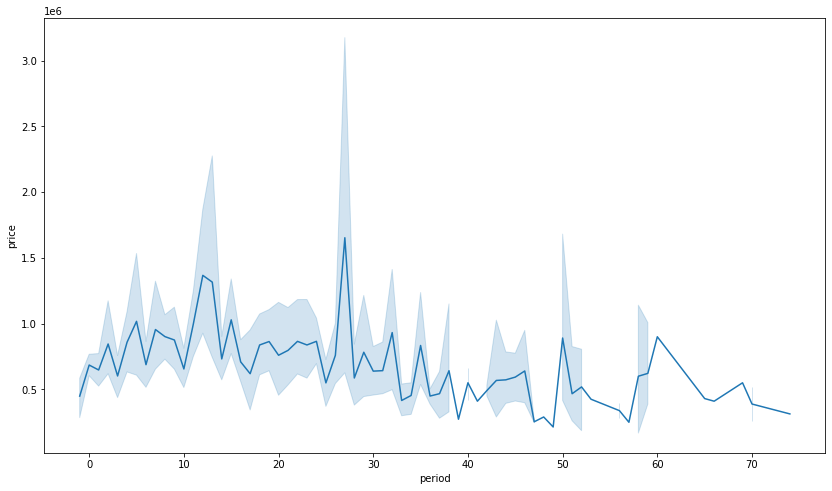

In [62]:
plt.figure(figsize=(14,8))
sns.lineplot(data=renovated, x='period', y='price')

- 재건축 후 집 구매 시점까지의 기간과 price의 관계에서는 눈에 띄는 관계는 뚜렷하게 보이지 않음

- 집이 지어지고 판매가 이루어진 기간과 price를 비교해보고자 함
- 재건축이 이뤄졌다면 재건축과 판매 시점의 기간을 비교하려고 함

In [63]:
data.loc[data['yr_renovated'] != 0, 'renovated'] = 1
data.loc[data['yr_renovated'] == 0, 'renovated'] = 0

- 재건축 여부를 원핫인코딩으로 나타냄

In [64]:
data.loc[data['yr_renovated'] != 0, 'period'] = (data['pur_Year'] - data['yr_renovated'])
data.loc[data['yr_renovated'] == 0, 'period'] = (data['pur_Year'] - data['yr_built'])

- 재건축 한 경우 : period = 판매년도 - 재건축한 년도
- 재건축 하지 않은 경우 : period = 판매년도 - 집 지어진 년도

In [65]:
data['period'].unique()

array([ 59.,  82.,  28.,  19.,  52.,  50.,  72.,  87.,  37., 115.,  36.,
        20.,  98.,  93.,  46.,  67.,  29.,  73.,  99., 105.,  11.,  85.,
        33.,  12., 110.,  18.,  30.,   0.,  92.,  49.,  64.,   6.,  55.,
        60.,  35.,  25.,   9.,  41.,  43.,  58.,  13.,  22.,  51.,  62.,
        89.,  53.,   8.,  26.,  14.,  75.,  48.,  39., 104.,  31.,  24.,
        34.,  15.,   4.,  69.,  65.,  90.,  47.,  88.,  10.,  68.,  38.,
        66.,  16.,  61.,   7., 113.,  21.,  27.,  94.,  45., 100.,  54.,
        74.,  96., 103.,  77., 107.,  84.,  40.,  17.,  71.,  63.,  23.,
        57.,  42.,   1.,   3.,  78.,  95.,   2.,  32., 102.,  97.,  56.,
       114.,  70.,  44.,   5.,  91.,  86., 109.,  76.,  83., 106., 108.,
       101., 111., 112.,  79.,  -1.,  81.,  80.])

- period가 -1인 경우를 알아봐야 함

In [66]:
data[data['period'] == -1][['pur_Year', 'yr_built', 'yr_renovated', 'period', 'price']]

,pur_Year,yr_built,yr_renovated,period,price
1264,2014,2015,0,-1.0,597326.0
1641,2014,1922,2015,-1.0,585000.0
1920,2014,2015,0,-1.0,385195.0
5002,2014,1940,2015,-1.0,285000.0
5303,2014,2015,0,-1.0,614285.0
5654,2014,2015,0,-1.0,455000.0
10110,2014,2015,0,-1.0,500000.0
11890,2014,2015,0,-1.0,350000.0
12907,2014,1945,2015,-1.0,476000.0
14428,2014,2015,0,-1.0,357000.0


- period가 -1인 경우는 두가지 경우가 존재함
- 첫번째 경우 : 지어지기 전에 구매한 경우
- 두번째 경우 : 2014년에 샀는데 2015년에 재건축한 경우
- 두번째의 경우에는 집 구매 시점에서 집이 지어진 기간이 상이하게 적용되기 때문에 (yr_built - pur_Year)을 해줄 예정

In [67]:
data.loc[data['period'] == -1, 'period'] = (data['pur_Year'] - data['yr_built'])

<AxesSubplot:xlabel='period', ylabel='price'>

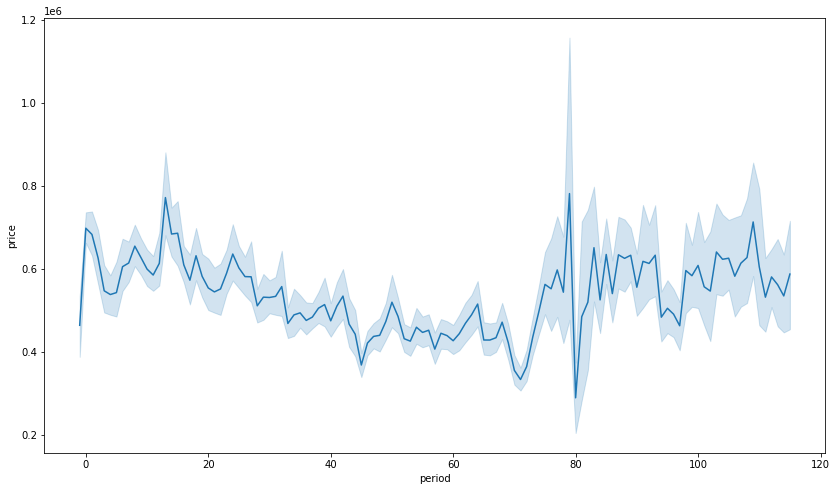

In [68]:
plt.figure(figsize=(14,8))
sns.lineplot(data=data, x='period', y='price')

- 집이 지어지고 난 후의 기간(재건축한 후의 기간)과 price의 그래프
- 집이 지어지고 약 70년까지는 price가 감소하는 추세를 보임
- 약 70년 이후에는 대체로 높은 가격대를 형성하는 것으로 판단됨

### 6. 경도와 위도

<AxesSubplot:xlabel='long', ylabel='lat'>

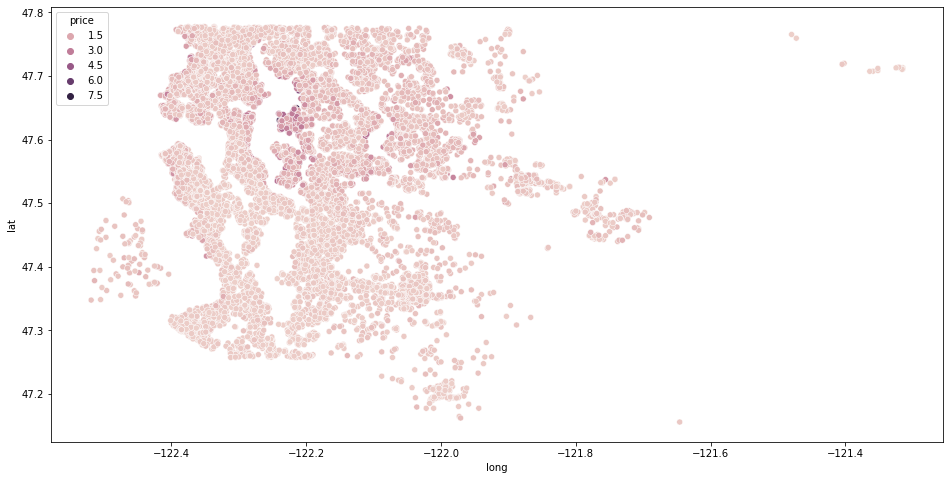

In [69]:
plt.figure(figsize=(16,8))
sns.scatterplot(data=data, x='long', y='lat', hue='price')

- 경도와 위도를 통해 집 가격을 본 결과 lat(위도)가 낮은 지역은 비싼 집이 적음

## feature 선정

In [70]:
data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'city', 'price_city_mean',
       'cheap', 'expensive', 'middle', 'very_cheap', 'very_expensive',
       'zipcode_re', 'pur_Year', 'renovated', 'period'],
      dtype='object')

In [71]:
x_col = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'zipcode_re', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'renovated', 'period']
len(x_col)

18

- x_col : feature 항목

In [72]:
data_feature = data[x_col]
data_feature.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode_re,lat,long,sqft_living15,sqft_lot15,renovated,period
0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,17,47.5112,-122.257,1340,5650,0.0,59.0
1,2,1.00,770,10000,1.0,0,0,3,6,770,0,2,47.7379,-122.233,2720,8062,0.0,82.0
2,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,7,47.6168,-122.045,1800,7503,0.0,28.0
3,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,0,47.3097,-122.327,2238,6819,0.0,19.0
4,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,19,47.4095,-122.315,1650,9711,0.0,52.0


In [73]:
y = data['price']
y.head()

0    221900.0
1    180000.0
2    510000.0
3    257500.0
4    291850.0
Name: price, dtype: float64

- y : label

**feature 제외 기준**
1. 'id' : 인덱스라서 feature에서 제외
2. 'date' : 영향력이 적은데 범주형 데이터여서 제외
3. 'zipcode' : zipcode를 통해서 zipcode_re를 추출해서 제외
4. 'city', 'price_city_mean' : 'cheap', 'middile', 'expensive', 'very_expensive'를 뽑기 위한 원핫원코딩 과정이어서 제외
7. 'yr_built', 'yr_renovated', 'pur_Year' : 'period'를 feature로 뽑기 위한 과정이어서 제외

## log 씌우기
- 전처리 과정에서 일부 변수에 따른 일부 집값이 비교적 매우 높게 측정됨
- log 제외 대상 : 원핫인코딩으로 feature에 채택된 변수
- kdeplot으로 feature들 안에서의 분포 상태를 체크해보고자 함
- https://igija.tistory.com/172

In [74]:
skew_columns = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15', 'period']

In [75]:
len(skew_columns)

13

In [76]:
x_col

['bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'zipcode_re',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15',
 'renovated',
 'period']

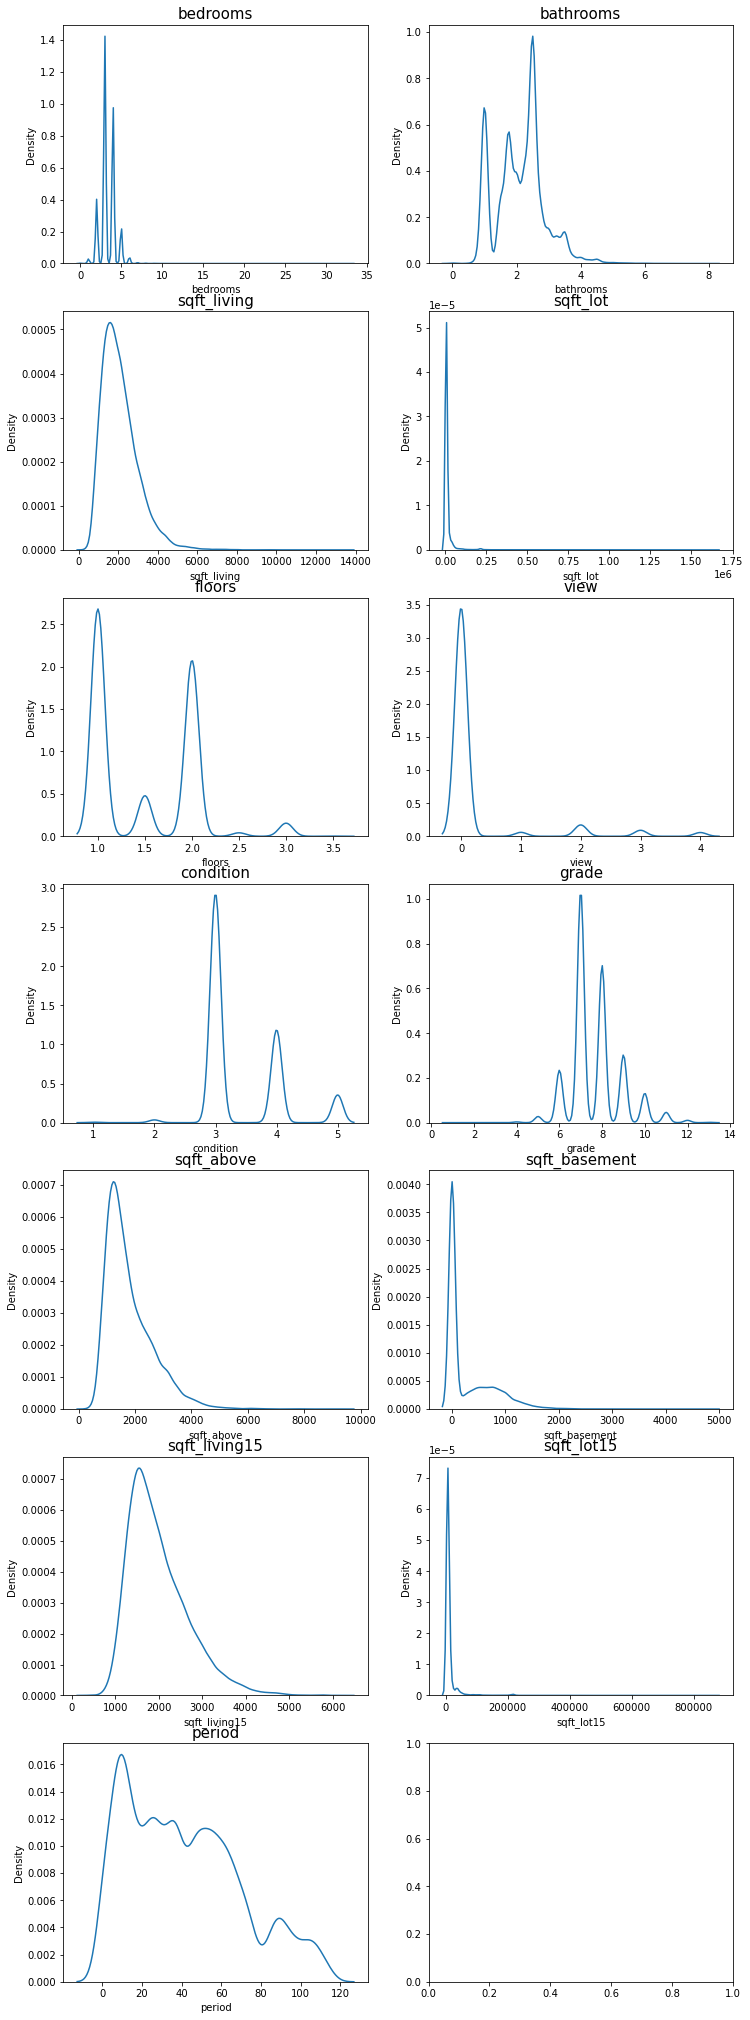

In [77]:
fig, ax = plt.subplots(7, 2, figsize=(12, 36))

count = 0
for row in range(7):
    for col in range(2):
        if count == 13:
            break
        sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count+=1

- 0의 값쪽에 몰려있는 feature들을 좀 더 고르게 분포시키고자함
- 전처리 과정에서 일부 값이 상대적으로 매우 높은 경향을 띔 -> 격차를 완화하고자 함

In [78]:
log_col = ['sqft_lot', 'sqft_lot15', 'bedrooms', 'sqft_living', 'view', 'sqft_above', 'sqft_basement', 'sqft_living15']

In [79]:
for c in log_col:
    data_feature[c] = np.log1p(data_feature[c].values)

In [80]:
y = np.log1p(y)

## data에서 train, test 분리

In [81]:
test = data_feature.iloc[train_len:, :]
train = data_feature.iloc[:train_len, :]

- 미리 지정한 train_len을 통해 인덱스로 train과 test를 slicing 해줌

In [82]:
train.shape, test.shape

((15035, 18), (6468, 18))

In [83]:
y = y.iloc[:train_len]

In [84]:
y.shape

(15035,)

- label도 train 데이터 수만큼 slicing

## 평가 지표 만들기 (RMSE)

In [85]:
from sklearn.metrics import mean_squared_error

In [86]:
def rmse(y_val, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_val), np.expm1(y_pred)))

- 캐글에서 제안한 RMSE로 모델을 평가해야 함
- sklearn에서 MSE는 제공하지만 RMSE는 제공하지 않으므로 mean_squared_error()를 통해 RMSE를 만들어줌

## 모델 적용

LGBMRegressor, XGBRegressor, RandomForestRegressor

In [87]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

In [88]:
random_state = 95

xgb = XGBRegressor(random_state=random_state)
lgbm = LGBMRegressor(random_state=random_state)
rf_rg = RandomForestRegressor(random_state=random_state)

models = [xgb, lgbm, rf_rg]

- XGB Regressor, LGBM Regressor, RandomForest Regressor 3가지로 평가해볼 예정임

In [89]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__   # 모델 이름 획득
        
        x_train, x_val, y_train, y_val = train_test_split(train, y, random_state=random_state, test_size=0.2)
        # 하이퍼 파라미터 조정을 위해 train셋에서 train과 validation으로 나눠줌
        
        model.fit(x_train, y_train)  # 모델 학습
        y_pred = model.predict(x_val) # 예측
        
        df[model_name] = rmse(y_val, y_pred)  # 예측 결과의 rmse값 저장
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=True)  # data frame에 저장
        
    return score_df

In [90]:
get_scores(models, train, y)

,RMSE
LGBMRegressor,113031.663945
XGBRegressor,118823.232015
RandomForestRegressor,135268.626075


- 하이퍼 파라미터를 조정하지 않았을 때, LGBMRegressor가 가장 좋은 성능을 보임

## 하이퍼 파라미터 튜닝 : Grid Search

In [91]:
from sklearn.model_selection import GridSearchCV

LightGBM Regressor의 하이퍼파라미터 디폴트값
- boosting_type='gbdt',
- num_leaves=31,
- max_depth=-1,
- learning_rate=0.1,
- n_estimators=100,
- subsample_for_bin=200000,
- objective=None,
- class_weight=None,

In [98]:
param_grid = {
    'num_leaves' : [30, 45, 60, 75],
    'learning_rate' : [0.1, 0.01],
    'n_estimators': [130, 145, 160, 175],
    'max_depth': [10, 15, 20, 25]
}

In [99]:
model = LGBMRegressor(random_state=random_state)

- 하이퍼 파라미터 튜닝 전 성능이 가장 좋게 나왔던 LGBMRegressor로 Grid Search를 해보려함

In [100]:
def GridSearch(model, train, y, param_grid, verbose=2, n_jobs=-1):
    grid_model = GridSearchCV(model, \
                              param_grid=param_grid, \
                              scoring='neg_mean_squared_error', \
                              cv=5, \
                              verbose=verbose, \
                              n_jobs=-n_jobs)
    
    grid_model.fit(train, y)  # 모델 학습
    
    params = grid_model.cv_results_['params']  # 각 하이퍼 파라미터 항목을 params에 지정
    score = grid_model.cv_results_['mean_test_score']  # 각 하이퍼 파라미터 변화에 따른 결과를 score에 지정
    
    results = pd.DataFrame(params)  # 각 하이퍼 파라미터들을 results라는 DataFrame으로 나타냄
    results['score'] = score  # results에 'score' 추가
    
    results['RMSLE'] = np.sqrt(-1 * results['score'])  # 결과는 'neg_mean_squared_error'이므로 -와 root를 씌워 RMSLE로 변환시켜줌
    results = results.sort_values('RMSLE', ascending=True)  # RMSLE 기준으로 sort함
    
    return results.head()

In [101]:
GridSearch(model, train, y, param_grid, verbose=0, n_jobs=-1)

,learning_rate,max_depth,n_estimators,num_leaves,score,RMSLE
9,0.1,10,160,45,-0.027410,0.165561
5,0.1,10,145,45,-0.027421,0.165593
21,0.1,15,145,45,-0.027423,0.165598
13,0.1,10,175,45,-0.027430,0.165619
1,0.1,10,130,45,-0.027439,0.165647


## 하이퍼 파라미터 튜닝 : Random Search

In [96]:
x_train, x_val, y_train, y_val = train_test_split(train, y, random_state=random_state, test_size=0.2)

In [102]:
hyper_list = []

for i in range(1000) :
    
    n_est = np.random.randint(145, 175)
    num_lvs = np.random.randint(30, 60)
    max_dep = np.random.randint(5, 20)
    ran_st = 95
    n_jobs = -1
    
    model = LGBMRegressor(n_estimators = n_est, 
                          num_leaves = num_lvs, 
                          learning_rate = 0.1, 
                          max_depth = max_dep, 
                          random_state = 95, 
                          n_jobs = -1)
    
    model.fit(x_train, y_train)
    y_pred = model.predict(x_val)
    
    RMSE = rmse(y_val, y_pred)
    
    hyper_list.append({'n_estimators' : n_est, 
                       'num_leaves' : num_lvs, 
                       'max_depth' : max_dep, 
                       'RMSE' : RMSE})
    
    if i % 100 == 0 :
        print(i, '번째')
    
history = pd.DataFrame(hyper_list).sort_values(by='RMSE', ascending=True)
history.head()

0 번째
100 번째
200 번째
300 번째
400 번째
500 번째
600 번째
700 번째
800 번째
900 번째


,n_estimators,num_leaves,max_depth,RMSE
469,171,50,14,108515.071659
721,170,50,14,108526.764296
124,174,50,14,108545.006770
808,168,30,12,108663.533557
465,174,30,12,108715.889647


## 하이퍼 파라미터 적용

In [104]:
model = LGBMRegressor(n_estimators=171, num_leaves=50, max_depth=14, learning_rate=0.1, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.19563944, 13.13030596, 14.14425604, ..., 13.02996551,
       12.6521693 , 13.01015611])

In [105]:
prediction = np.expm1(prediction)
prediction

array([ 538012.77294224,  503986.10506952, 1389223.22598407, ...,
        455870.16415188,  312439.49146297,  446928.48571006])

## submission 파일에 적용 및 캐글에 제출

In [106]:
"""
아래의 과정을 수행하는 `save_submission(model, train, y, test, model_name, rmsle)` 함수를 구현해 주세요.
1. 모델을 `train`, `y`로 학습시킵니다.
2. `test`에 대해 예측합니다.
3. 예측값을 `np.expm1`으로 변환하고, `submission_model_name_RMSLE_100000.csv` 형태의 `csv` 파일을 저장합니다.
"""

def save_submission(model, train, y, test, model_name, rmse=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = '../Data/Exploration.05/kaggle-kakr-housing-data/data/'
    submission_path = '../Data/Exploration.05/kaggle-kakr-housing-data/data/sample_submission.csv'
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSE_{}.csv'.format(data_dir, model_name, rmse)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [107]:
save_submission(model, train, y, test, 'lgbm', 108515)

../Data/Exploration.05/kaggle-kakr-housing-data/data//submission_lgbm_RMSE_108515.csv saved!


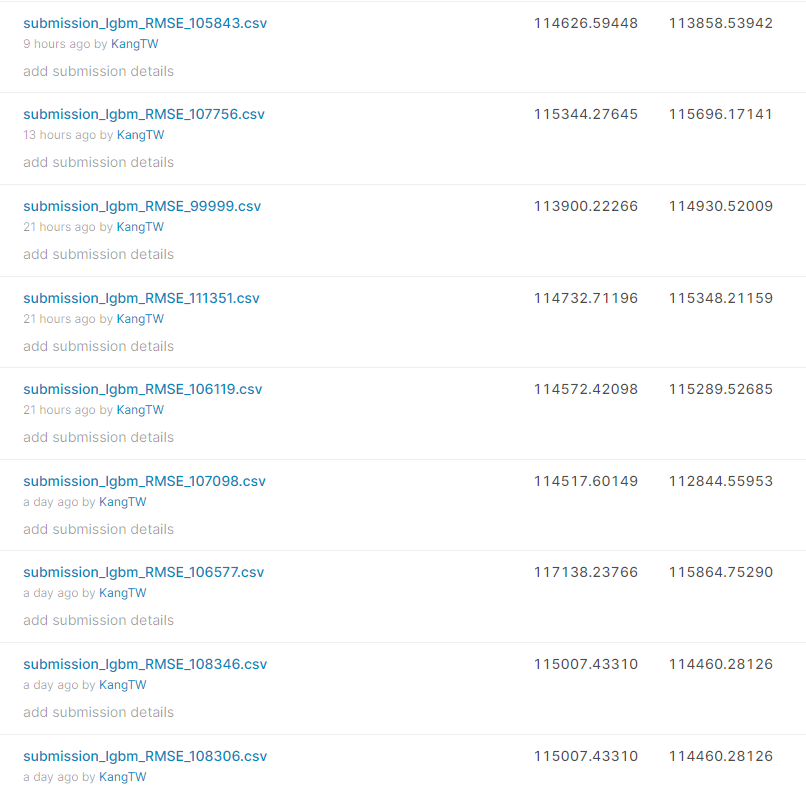

## 회고

### 1. 새로 알아갔던 점
 - 데이터에 log를 씌워 데이터 값의 분포를 변화시킬 수 있다는 것


### 2. 흥미로웠던 점
 - 캐글 코리아도 번역에 실수를 한다는 것이 재밌었음
 - EDA 과정에서 여러 가지를 생각해보며 구현해보는 점이 흥미로웠음
 - lightGBM의 하이퍼 파라미터 튜닝을 하며 어떻게 접근해야할지 생각해보는게 흥미로웠음


### 3. 아쉬웠던 점
 - 여러가지 실험을 하기엔 시간이 부족했다는 것이 아쉬웠음
 - 마지막에 하이퍼 파라미터 튜닝에 너무 몰두하였지만 전처리가 덜 되어서 아쉬웠음
 - 지금까지 실험한 하이퍼 파라미터 튜닝을 이 글에 담기 어려워서 아쉬웠음
 - 최종적으로 하이퍼 파라미터를 구체화 시키다가 제출 시간이 임박하여 빨리 돌릴 수 있는 하이퍼 파라미터로 변경하여 제출하는게 아쉬웠음


### 4. 앞으로의 다짐
 - 회귀모델 문제를 좀 더 다뤄봐서 익숙해져야겠다는 생각을 함